In [1]:
import os 
import getpass
from typing import Annotated, Dict, List, Any
from typing_extensions import TypedDict

def setup_environment():
    """Setup your API KEYs"""
    if not os.environ.get("OPENAI_API_KEY"):
        openai_key = getpass.getpass("Enter your OPENAI API KEY")
        os.environ["OPENAI_API_KEY"] = openai_key

    if not os.environ.get("LANGSMITH_API_KEY"):
        langsmith_key = getpass.getpass("ENTER your LAngsmith API KEY")
        if langsmith_key:
            os.environ["LANGSMITH_API_KEY"] = langsmith_key
            os.environ["LANGCHAIN_TRACING_V2"] ="true"
            os.environ["LANGCHAIN_PROJECT"] = "Langgraph tutorial"
        else:
            print("skipping langsmith set up")


    print("Envioenment setup completed")

    Task:
    Create a Personal Assistant Agent that can:
    Have basic conversations
    Remember user's name and preferences across sessions
    Perform simple calculations
    Tell current time/date

In [2]:
setup_environment()

Envioenment setup completed


In [3]:
from langgraph.graph import StateGraph , START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated 
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
import datetime
import math


class State(TypedDict):
    # messages will store our conversation history
    ### add_messages is a special function  that append new message instead of replacing them

    messages: Annotated[list, add_messages]


In [4]:


llm = ChatOpenAI(
    model = "gpt-4o",
    temperature= 0.0
)

llm.invoke("Hi").content

'Hello! How can I assist you today?'

In [5]:
@tool
def get_current_time() -> str:
    """Get the current time and date."""
    return f"Current time is {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression safely.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., "2 + 3 * 4")
        
    Returns:
        The result of the calculation
    """
    try:
        # Safe evaluation of mathematical expressions
        # Only allow basic math operations
        allowed_names = {
            k: v for k, v in math.__dict__.items() if not k.startswith("__")
        }
        allowed_names.update({"abs": abs, "round": round})
        
        result = eval(expression, {"__builtins__": {}}, allowed_names)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculating {expression}: {str(e)}"


In [6]:
tools = [get_current_time, calculator]

llm_with_tools = llm.bind_tools(tools)

def chatbot(state):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


  

### Using an In-Memory Checkpointer (Ephemeral Memory)

This setup uses LangGraph's built-in in-memory checkpointer. It stores conversation state in memory only (not persisted to disk)
This allows multi-turn conversations within a running program, but the memory resets when the program stops.

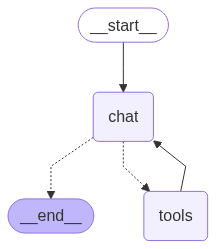

In [7]:

# Initialize memory checkpoint
checkpointer = InMemorySaver()
# memory = MemorySaver(State)
graph_builder = StateGraph(State)
graph_builder.add_node("chat", chatbot)
tools = ToolNode(tools)
graph_builder.add_node("tools", tools)
graph_builder.add_edge(START, "chat")
graph_builder.add_conditional_edges("chat", tools_condition)
graph_builder.add_edge("tools","chat")
graph = graph_builder.compile(checkpointer=checkpointer)



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




In [8]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages":[{"role":'user',"content":"Hello! my name is amit I take lectures on BIA"}]}, config)

{'messages': [HumanMessage(content='Hello! my name is amit I take lectures on BIA', additional_kwargs={}, response_metadata={}, id='b1b5bc01-c51f-4def-8947-12dd36fd03f6'),
  AIMessage(content="Hello Amit! It's great to meet you. Teaching Business Intelligence and Analytics (BIA) sounds fascinating. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 101, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BtXsVSrEqw43pJzAkSDsflTkhmbWI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc9dbd69-d012-4fdb-96ff-3fd06531cae8-0', usage_metadata={'input_tokens': 101, 'output_tokens': 29, 'total_tokens': 130, 'input_token_

In [9]:
graph.invoke({"messages":[{"role":"user","content": "Do you remember my name and what I do"}]}, config)

{'messages': [HumanMessage(content='Hello! my name is amit I take lectures on BIA', additional_kwargs={}, response_metadata={}, id='b1b5bc01-c51f-4def-8947-12dd36fd03f6'),
  AIMessage(content="Hello Amit! It's great to meet you. Teaching Business Intelligence and Analytics (BIA) sounds fascinating. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 101, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BtXsVSrEqw43pJzAkSDsflTkhmbWI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc9dbd69-d012-4fdb-96ff-3fd06531cae8-0', usage_metadata={'input_tokens': 101, 'output_tokens': 29, 'total_tokens': 130, 'input_token_

In [10]:
graph.invoke({"messages":[{"role":"user","content": "whats the time"}]}, config)

{'messages': [HumanMessage(content='Hello! my name is amit I take lectures on BIA', additional_kwargs={}, response_metadata={}, id='b1b5bc01-c51f-4def-8947-12dd36fd03f6'),
  AIMessage(content="Hello Amit! It's great to meet you. Teaching Business Intelligence and Analytics (BIA) sounds fascinating. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 101, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BtXsVSrEqw43pJzAkSDsflTkhmbWI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc9dbd69-d012-4fdb-96ff-3fd06531cae8-0', usage_metadata={'input_tokens': 101, 'output_tokens': 29, 'total_tokens': 130, 'input_token_

In [11]:
graph.invoke({"messages":[{"role":"user","content": "whats the value of 3+4"}]}, config)

{'messages': [HumanMessage(content='Hello! my name is amit I take lectures on BIA', additional_kwargs={}, response_metadata={}, id='b1b5bc01-c51f-4def-8947-12dd36fd03f6'),
  AIMessage(content="Hello Amit! It's great to meet you. Teaching Business Intelligence and Analytics (BIA) sounds fascinating. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 101, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BtXsVSrEqw43pJzAkSDsflTkhmbWI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc9dbd69-d012-4fdb-96ff-3fd06531cae8-0', usage_metadata={'input_tokens': 101, 'output_tokens': 29, 'total_tokens': 130, 'input_token_

###  Using a Redis Checkpointer (Persistent Memory with Redis)
For persistent, fast storage of conversation state across sessions, LangGraph provides a Redis-backed checkpointer. This requires a running Redis server and the langgraph-checkpoint-redis integration package
langchain-ai.github.io
. The state (conversation history) is saved in Redis so the agent can recall information even after the program restarts
redis.io


In [18]:
# docker run -d -p 6379:6379 --name redis-stack redis/redis-stack-server:latest
# from langgraph.checkpoint.redis import RedisSaver
# from langgraph.graph import StateGraph, MessagesState, START
# from langchain_openai import ChatOpenAI

# # Connect to Redis (adjust URL as needed; here we use default local Redis)
# DB_URI = "redis://localhost:6379"
# with RedisSaver.from_conn_string(DB_URI) as checkpointer:  # open Redis connection
#     checkpointer.setup()  # initialize Redis schema on first use (creates indexes):contentReference[oaicite:13]{index=13}
#     model = ChatOpenAI(temperature=0)
#     def call_model(state: MessagesState):
#         response = model(state["messages"])
#         return {"messages": response}

#     builder = StateGraph(MessagesState)
#     builder.add_node(call_model)
#     builder.add_edge(START, "call_model")
#     graph = builder.compile(checkpointer=checkpointer)
#     config = {"configurable": {"thread_id": "user123"}}

#     # **Session 1:** User introduces themselves (state will be saved to Redis)
#     graph.invoke(
#         {"messages": [{"role": "user", "content": "Hi, I'm Alice and I love chocolate."}]}, 
#         config
#     )
#     # The assistant's reply is now stored in Redis under thread "user123".

# # (At this point, the program could exit; the conversation state remains in Redis)

# # **Session 2:** Later on, we reconnect to Redis and resume the conversation
# with RedisSaver.from_conn_string(DB_URI) as checkpointer:  # re-open Redis connection
#     model = ChatOpenAI(temperature=0)
#     def call_model(state: MessagesState):
#         response = model(state["messages"])
#         return {"messages": response}

#     builder = StateGraph(MessagesState)
#     builder.add_node(call_model)
#     builder.add_edge(START, "call_model")
#     graph = builder.compile(checkpointer=checkpointer)
#     config = {"configurable": {"thread_id": "user123"}}

#     # User asks a question in a new session; the agent will load prior state from Redis
#     result = graph.invoke(
#         {"messages": [{"role": "user", "content": "Do you remember my name and what I like?"}]}, 
#         config
#     )
#     print(result["messages"][-1]["content"])
#     # Expected: "Yes, your name is Alice and you like chocolate."


### Using a SQLite Checkpointer (Persistent Local Memory)

In [21]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, MessagesState, START
from langchain_openai import ChatOpenAI

DB_PATH = "memory_store.db"  # SQLite database file for storing checkpoints

# **Session 1:** Create/open the SQLite DB and save the conversation state
with SqliteSaver.from_conn_string(DB_PATH) as checkpointer:  # opens connection to memory_store.db
    model = ChatOpenAI(temperature=0)
    def call_model(state: MessagesState):
        response = model(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node(call_model)
    builder.add_edge(START, "call_model")
    graph = builder.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "user123"}}

    # User introduces themselves; state is saved to the SQLite file
    graph.invoke(
        {"messages":[{"role":'user',"content":"Hello! my name is amit I take lectures on BIA"}]}, 
        config
    )
    # After this call, the conversation (thread "user123") is stored in memory_store.db

# **Session 2:** Re-open the SQLite DB and resume the conversation
with SqliteSaver.from_conn_string(DB_PATH) as checkpointer:  # connect to the same DB file
    model = ChatOpenAI(temperature=0)
    def call_model(state: MessagesState):
        response = model(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node(call_model)
    builder.add_edge(START, "call_model")
    graph = builder.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "user123"}}

    # User asks a follow-up; the agent loads past state from the SQLite DB
    result = graph.invoke(
        {"messages": [{"role": "user", "content": "Do you remember my name and what I do?"}]}, 
        config
    )
    print(result["messages"][-1])
    # Expected agent output: "Your name is Alice and you like chocolate."


15:58:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
15:58:57 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
content="Yes, Amit! You mentioned that you take lectures on Business Intelligence and Analytics. It's great to chat with you. What do you find most rewarding about teaching in that field?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 242, 'total_tokens': 278, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtXC40WGWU5zKtINMYA77p0fCQ9PE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--fe351b97-fed6-40ce-be50-426804e43a90-0' usage_metadata={'input_tokens':

### Multi-Tool Research Assistant
    Task:
    Build a Research Assistant that can:
    Search the web for information [https://serpapi.com/]
    Summarize articles
    Save findings to a file
    Generate a final research report